In [1]:
import time
import itertools
import time, os, fnmatch, shutil
import pickle
import re
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

%matplotlib inline

from __future__ import print_function, division
import requests

Import inpatient data, outpatient data and hospital information

In [3]:
import pandas as pd
folder = '/Users/torrie/Documents/Metis_Project_3_(McNulty)/'
df_ip_payments = pd.read_csv(folder + 'Inpatient_Prospective_Payment_System__IPPS__Provider_Summary_for_the_Top_100_Diagnosis-Related_Groups__DRG__-_FY2011.csv')
df_op_payments = pd.read_csv(folder + 'Medicare_Provider_Charge_Outpatient_APC32_CY2014.csv')
df_hospitals = pd.read_csv(folder + 'Hospital_General_Information.csv')

Fix column titles:

In [4]:
df_ip_payments.columns = df_ip_payments.columns.str.strip()
df_ip_payments.columns = df_ip_payments.columns.str.replace(' ','_')
df_ip_payments.columns

Index([u'DRG_Definition', u'Provider_Id', u'Provider_Name',
       u'Provider_Street_Address', u'Provider_City', u'Provider_State',
       u'Provider_Zip_Code', u'Hospital_Referral_Region_Description',
       u'Total_Discharges', u'Average_Covered_Charges',
       u'Average_Total_Payments', u'Average_Medicare_Payments'],
      dtype='object')

In [5]:
df_hospitals.columns = df_hospitals.columns.str.strip()
df_hospitals.columns = df_hospitals.columns.str.replace(' ','_')
df_hospitals.columns

Index([u'Provider_ID', u'Hospital_Name', u'Address', u'City', u'State',
       u'ZIP_Code', u'County_Name', u'Phone_Number', u'Hospital_Type',
       u'Hospital_Ownership', u'Emergency_Services',
       u'Meets_criteria_for_meaningful_use_of_EHRs',
       u'Hospital_overall_rating', u'Hospital_overall_rating_footnote',
       u'Mortality_national_comparison',
       u'Mortality_national_comparison_footnote',
       u'Safety_of_care_national_comparison',
       u'Safety_of_care_national_comparison_footnote',
       u'Readmission_national_comparison',
       u'Readmission_national_comparison_footnote',
       u'Patient_experience_national_comparison',
       u'Patient_experience_national_comparison_footnote',
       u'Effectiveness_of_care_national_comparison',
       u'Effectiveness_of_care_national_comparison_footnote',
       u'Timeliness_of_care_national_comparison',
       u'Timeliness_of_care_national_comparison_footnote',
       u'Efficient_use_of_medical_imaging_national_comparis

In [6]:
df_op_payments.columns = df_op_payments.columns.str.strip()
df_op_payments.columns = df_op_payments.columns.str.replace(' ','_')
df_op_payments.columns

Index([u'apc', u'provider_id', u'provider_name', u'Provider_Street_Address',
       u'Provider_City', u'Provider_State', u'Provider_Zip_Code',
       u'Hospital_Referral_Region', u'Outpatient_Services',
       u'Average_Estimated_Submitted_Charges', u'Average_Total_Payments'],
      dtype='object')

Check data types:

In [7]:
df_op_payments.dtypes

apc                                     object
provider_id                              int64
provider_name                           object
Provider_Street_Address                 object
Provider_City                           object
Provider_State                          object
Provider_Zip_Code                        int64
Hospital_Referral_Region                object
Outpatient_Services                      int64
Average_Estimated_Submitted_Charges    float64
Average_Total_Payments                 float64
dtype: object

In [8]:
df_ip_payments.dtypes

DRG_Definition                          object
Provider_Id                              int64
Provider_Name                           object
Provider_Street_Address                 object
Provider_City                           object
Provider_State                          object
Provider_Zip_Code                        int64
Hospital_Referral_Region_Description    object
Total_Discharges                         int64
Average_Covered_Charges                 object
Average_Total_Payments                  object
Average_Medicare_Payments               object
dtype: object

In [9]:
df_hospitals.dtypes

Provider_ID                                                        int64
Hospital_Name                                                     object
Address                                                           object
City                                                              object
State                                                             object
ZIP_Code                                                           int64
County_Name                                                       object
Phone_Number                                                       int64
Hospital_Type                                                     object
Hospital_Ownership                                                object
Emergency_Services                                                  bool
Meets_criteria_for_meaningful_use_of_EHRs                         object
Hospital_overall_rating                                           object
Hospital_overall_rating_footnote                   

Clean '$' and ',' from data:

In [10]:
df_ip_payments['Average_Covered_Charges']= df_ip_payments['Average_Covered_Charges'].str.replace("$",'')
df_ip_payments['Average_Covered_Charges']= df_ip_payments['Average_Covered_Charges'].str.replace(",",'')




In [11]:
df_ip_payments['Average_Total_Payments']= df_ip_payments['Average_Total_Payments'].str.replace("$",'')
df_ip_payments['Average_Total_Payments']= df_ip_payments['Average_Total_Payments'].str.replace(",",'')



In [12]:
df_ip_payments['Average_Medicare_Payments']= df_ip_payments['Average_Medicare_Payments'].str.replace("$",'')
df_ip_payments['Average_Medicare_Payments']= df_ip_payments['Average_Medicare_Payments'].str.replace(",",'')



In [13]:
df_ip_payments.head()

,DRG_Definition,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_Description,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44


Convert text to numbers:

In [14]:
df_ip_payments['Average_Medicare_Payments']= pd.to_numeric(df_ip_payments['Average_Medicare_Payments'])

In [15]:
df_ip_payments['Average_Total_Payments']= pd.to_numeric(df_ip_payments['Average_Total_Payments'])

In [16]:
df_ip_payments['Average_Covered_Charges']= pd.to_numeric(df_ip_payments['Average_Covered_Charges'])

Check that data types have been updated:

In [17]:
df_ip_payments.dtypes

DRG_Definition                           object
Provider_Id                               int64
Provider_Name                            object
Provider_Street_Address                  object
Provider_City                            object
Provider_State                           object
Provider_Zip_Code                         int64
Hospital_Referral_Region_Description     object
Total_Discharges                          int64
Average_Covered_Charges                 float64
Average_Total_Payments                  float64
Average_Medicare_Payments               float64
dtype: object

Check the distribution of each type of payment:

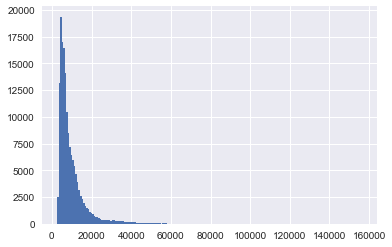

In [18]:
df_ip_payments['Average_Total_Payments'].hist(bins = 200)

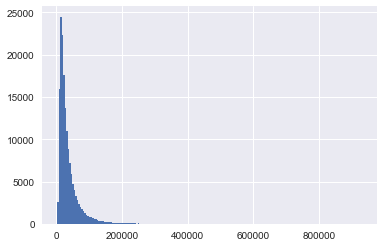

In [19]:
df_ip_payments['Average_Covered_Charges'].hist(bins = 200)

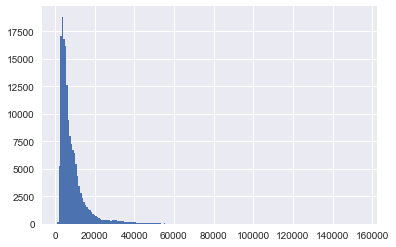

In [20]:
df_ip_payments['Average_Medicare_Payments'].hist(bins = 200)

Data is non-normal and right skewed for all payments/charges

Look at hospital dataframe:

In [21]:
df_hospitals.dtypes

Provider_ID                                                        int64
Hospital_Name                                                     object
Address                                                           object
City                                                              object
State                                                             object
ZIP_Code                                                           int64
County_Name                                                       object
Phone_Number                                                       int64
Hospital_Type                                                     object
Hospital_Ownership                                                object
Emergency_Services                                                  bool
Meets_criteria_for_meaningful_use_of_EHRs                         object
Hospital_overall_rating                                           object
Hospital_overall_rating_footnote                   

Make a copy and drop the columns that are not pertinent:

In [22]:
df_hospital_info = df_hospitals.copy()

In [23]:
df_hospital_info = df_hospital_info.drop(['Address','City','State','ZIP_Code','Phone_Number','Hospital_overall_rating_footnote','Mortality_national_comparison_footnote','Safety_of_care_national_comparison_footnote','Readmission_national_comparison_footnote','Patient_experience_national_comparison_footnote','Effectiveness_of_care_national_comparison_footnote','Timeliness_of_care_national_comparison_footnote','Efficient_use_of_medical_imaging_national_comparison_footnote','Location'],1)




In [24]:
df_hospital_info.dtypes

Provider_ID                                              int64
Hospital_Name                                           object
County_Name                                             object
Hospital_Type                                           object
Hospital_Ownership                                      object
Emergency_Services                                        bool
Meets_criteria_for_meaningful_use_of_EHRs               object
Hospital_overall_rating                                 object
Mortality_national_comparison                           object
Safety_of_care_national_comparison                      object
Readmission_national_comparison                         object
Patient_experience_national_comparison                  object
Effectiveness_of_care_national_comparison               object
Timeliness_of_care_national_comparison                  object
Efficient_use_of_medical_imaging_national_comparison    object
dtype: object

In [25]:
df_ip_payments.rename(columns={'Provider_Id': 'Provider_ID'}, inplace=True)


In [26]:
df_ip_payments.dtypes

DRG_Definition                           object
Provider_ID                               int64
Provider_Name                            object
Provider_Street_Address                  object
Provider_City                            object
Provider_State                           object
Provider_Zip_Code                         int64
Hospital_Referral_Region_Description     object
Total_Discharges                          int64
Average_Covered_Charges                 float64
Average_Total_Payments                  float64
Average_Medicare_Payments               float64
dtype: object

Make a copy of the inpatient dataframe and merge with the cleaned provider dataframe on the provider ID. I want to keep all the columns and rows and used a left merge (there will be N/A's in the hospital info colums if a corresponding charge does not exist):

In [27]:
df_ip_payments_copy = df_ip_payments.copy()

In [28]:
df_IPandProvider = pd.merge(df_ip_payments_copy, df_hospital_info, on='Provider_ID', how = 'left')

In [29]:
df_IPandProvider.dtypes

DRG_Definition                                           object
Provider_ID                                               int64
Provider_Name                                            object
Provider_Street_Address                                  object
Provider_City                                            object
Provider_State                                           object
Provider_Zip_Code                                         int64
Hospital_Referral_Region_Description                     object
Total_Discharges                                          int64
Average_Covered_Charges                                 float64
Average_Total_Payments                                  float64
Average_Medicare_Payments                               float64
Hospital_Name                                            object
County_Name                                              object
Hospital_Type                                            object
Hospital_Ownership                      

Calculte the amount paid by the patient (hospital charge - medicare payment). Just curious about the number, I will not use it in analysis because it is unverified:

In [30]:
#df_IPandProvider['Average_Total_Payments'].iloc[1] - df_IPandProvider['Average_Medicare_Payments'].iloc[1]
df_IPandProvider['Patient_payment'] = df_IPandProvider['Average_Total_Payments'] - df_IPandProvider['Average_Medicare_Payments']


Pick a charge type and look at the numbers:

In [33]:
stats = df_IPandProvider[df_IPandProvider.DRG_Definition == '885 - PSYCHOSES'].mean()

In [34]:
stats

Provider_ID                  249210.380098
Provider_Zip_Code             46881.869494
Total_Discharges                146.383361
Average_Covered_Charges       19929.451387
Average_Total_Payments         6968.721876
Average_Medicare_Payments      5864.125644
Patient_payment                1104.596232
dtype: float64

Make dictionaries of each charge type and the mean:

In [35]:
#df_IPandProvider['Average_Medicare_Payments'][df_IPandProvider[df_IPandProvider.DRG_Definition == '101 - SEIZURES W/O MCC']].mean()
covered_charges_dict = {}
total_payments_dict = {}
medicare_payments_dict = {}
patient_payments_dict = {}

for charge_type in df_IPandProvider.DRG_Definition.unique():
    #stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
    #stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
    
    if covered_charges_dict.has_key(charge_type):
        pass
    else:
        stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
        stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
        covered_charges_dict[charge_type] = [stats[(3)],stdev[(3)]]
        
    if total_payments_dict.has_key(charge_type):
        pass
    else:
        stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
        stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
        total_payments_dict[charge_type] = [stats[(4)],stdev[(4)]]
        
    if medicare_payments_dict.has_key(charge_type):
        pass
    else:
        stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
        stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
        medicare_payments_dict[charge_type] = [stats[(5)],stdev[(5)]]
          
    if patient_payments_dict.has_key(charge_type):
        pass
    else:
        stats = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].mean()
        stdev = df_IPandProvider[df_IPandProvider.DRG_Definition == charge_type].std()
        patient_payments_dict[charge_type] = [stats[(6)],stdev[(6)]]
        
    #print("covered charges =",stats[(3)],'+/-',stdev[(3)]) 
    #print("total payments =",stats[(4)],'+/-',stdev[(4)])   
    #print("medicare payments =",stats[(5)],'+/-',stdev[(5)])   
#print(type(check))                                                               
#covered_charges_dict.keys()
#check[(1)]

In [36]:
patient_payments_dict['252 - OTHER VASCULAR PROCEDURES W MCC']

[1477.7635794960916, 2070.3149126298654]

Make a df to check calculations on

In [37]:
check_df = df_IPandProvider.copy()

In [38]:
check_df = check_df.sample(n=100)

In [39]:
check_df.head()

,DRG_Definition,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_Description,Total_Discharges,Average_Covered_Charges,...,Meets_criteria_for_meaningful_use_of_EHRs,Hospital_overall_rating,Mortality_national_comparison,Safety_of_care_national_comparison,Readmission_national_comparison,Patient_experience_national_comparison,Effectiveness_of_care_national_comparison,Timeliness_of_care_national_comparison,Efficient_use_of_medical_imaging_national_comparison,Patient_payment
146047,699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC,290046,SPRING VALLEY HOSPITAL MEDICAL CENTER,5400 SOUTH RAINBOW BLVD,LAS VEGAS,NV,89118,NV - Las Vegas,15,31609.13,...,True,2,Same as the National average,Below the National average,Below the National average,Below the National average,Same as the National average,Below the National average,Same as the National average,2049.87
149117,812 - RED BLOOD CELL DISORDERS W/O MCC,340116,FRYE REGIONAL MEDICAL CENTER,420 N CENTER ST,HICKORY,NC,28601,NC - Hickory,30,24162.60,...,True,3,Below the National average,Above the National average,Above the National average,Same as the National average,Same as the National average,Same as the National average,Above the National average,976.80
94781,378 - G.I. HEMORRHAGE W CC,370078,OKLAHOMA STATE UNIVERSITY MEDICAL CENTER,744 WEST 9TH STREET,TULSA,OK,74127,OK - Tulsa,31,22945.74,...,True,2,Same as the National average,Above the National average,Below the National average,Below the National average,Below the National average,Above the National average,Same as the National average,923.26
156724,872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...,340099,ROANOKE CHOWAN HOSPITAL,500 S ACADEMY ST,AHOSKIE,NC,27910,NC - Greenville,68,16823.52,...,True,3,Same as the National average,Same as the National average,Below the National average,Same as the National average,Same as the National average,Same as the National average,Same as the National average,774.88
13923,176 - PULMONARY EMBOLISM W/O MCC,140172,FRANCISCAN ST JAMES HEALTH,20201 S CRAWFORD AVENUE,OLYMPIA FIELDS,IL,60461,IL - Blue Island,52,30023.82,...,True,1,Above the National average,Below the National average,Below the National average,Below the National average,Same as the National average,Same as the National average,Same as the National average,1426.25


Add columns with "1", "2", or "3" to describe whether value is <, ~, or > mean for the procedure 

In [41]:
covered_charges = []
covered_charges_average = []
covered_charges_std = []
total_payments = []
total_payments_average = []
total_payments_std = []
medicare_payments = []
medicare_payments_average = []
medicare_payments_std = []
subject_payments = []
subject_payments_average = []
subject_payments_std = []


n=0

for charge in check_df.itertuples():
    #print(charge)
    category = check_df['DRG_Definition'].iloc[n]
    print(category)
   
    # Covered Charges
    if check_df['Average_Covered_Charges'].iloc[n] > (covered_charges_dict[category][0]+(0.5*covered_charges_dict[category][1])):
        covered_charges.append('2')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    elif check_df['Average_Covered_Charges'].iloc[n] < (covered_charges_dict[category][0]-(0.5*covered_charges_dict[category][1])):
        covered_charges.append('0')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    else:
        covered_charges.append('1')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    
     #Total Payment
    if check_df['Average_Total_Payments'].iloc[n] > (total_payments_dict[category][0]+(0.25*total_payments_dict[category][1])):
        total_payments.append('2')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    elif check_df['Average_Total_Payments'].iloc[n] < (total_payments_dict[category][0]-(0.25*total_payments_dict[category][1])):
        total_payments.append('0')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    else:
        total_payments.append('1')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    
    #Medicare Payment   
    if check_df['Average_Medicare_Payments'].iloc[n] > (medicare_payments_dict[category][0]+(0.25*medicare_payments_dict[category][1])):
        medicare_payments.append('2')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])      
    elif check_df['Average_Medicare_Payments'].iloc[n] < (medicare_payments_dict[category][0]-(0.25*medicare_payments_dict[category][1])):
        medicare_payments.append('0')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])
    else:
        medicare_payments.append('1')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])
    
    #Subject Payment 
    if check_df['Patient_payment'].iloc[n] > (patient_payments_dict[category][0]+(0.25*patient_payments_dict[category][1])):
        subject_payments.append('2')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])      
    elif check_df['Patient_payment'].iloc[n] < (patient_payments_dict[category][0]-(0.25*patient_payments_dict[category][1])):
        subject_payments.append('0')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])
    else:
        subject_payments.append('1')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])
        
    n=n+1
    
check_df['Covered_Charges'] = covered_charges
check_df['Covered_Charges_Avg'] = covered_charges_average
check_df['Covered_Charges_Stdev'] = covered_charges_std

check_df['Total_Payments'] = total_payments    
check_df['Total_Payments_Avg'] = total_payments_average
check_df['Total_Payments_Stdev'] = total_payments_std


check_df['Medicare_Payments'] = medicare_payments
check_df['Medicare_Payments_Avg'] = medicare_payments_average
check_df['Medicare_Payments_Std'] = medicare_payments_std

check_df['Patient_Payments'] = subject_payments
check_df['Patient_Payments_Avg'] = subject_payments_average
check_df['Patient_Payments_Stdev'] = subject_payments_std



699 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W CC
812 - RED BLOOD CELL DISORDERS W/O MCC
378 - G.I. HEMORRHAGE W CC
872 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W/O MCC
176 - PULMONARY EMBOLISM W/O MCC
918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC
194 - SIMPLE PNEUMONIA & PLEURISY W CC
811 - RED BLOOD CELL DISORDERS W MCC
563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP, PELVIS & THIGH W/O MCC
394 - OTHER DIGESTIVE SYSTEM DIAGNOSES W CC
481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOINT W CC
563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP, PELVIS & THIGH W/O MCC
811 - RED BLOOD CELL DISORDERS W MCC
536 - FRACTURES OF HIP & PELVIS W/O MCC
101 - SEIZURES W/O MCC
292 - HEART FAILURE & SHOCK W CC
308 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W MCC
309 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W CC
178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC
683 - RENAL FAILURE W CC
286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD CATH W MCC
191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC
552 - ME

In [42]:
check_df['Covered_Charges'].value_counts()

1    40
0    34
2    26
Name: Covered_Charges, dtype: int64

In [43]:
check_df['Total_Payments'].value_counts()

0    56
2    26
1    18
Name: Total_Payments, dtype: int64

In [44]:
check_df['Medicare_Payments'].value_counts()

0    56
2    26
1    18
Name: Medicare_Payments, dtype: int64

In [45]:
check_df['Patient_Payments'].value_counts()

0    46
1    30
2    24
Name: Patient_Payments, dtype: int64

Worked! Now do calculations on the entire dataset

In [406]:
covered_charges = []
covered_charges_average = []
covered_charges_std = []
total_payments = []
total_payments_average = []
total_payments_std = []
medicare_payments = []
medicare_payments_average = []
medicare_payments_std = []
subject_payments = []
subject_payments_average = []
subject_payments_std = []


n=0

for charge in df_IPandProvider.itertuples():
    #print(charge)
    category = df_IPandProvider['DRG_Definition'].iloc[n]
    #print(category)
   
    # Covered Charges
    if df_IPandProvider['Average_Covered_Charges'].iloc[n] > (covered_charges_dict[category][0]+(0.25*covered_charges_dict[category][1])):
        covered_charges.append('2')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    elif df_IPandProvider['Average_Covered_Charges'].iloc[n] < (covered_charges_dict[category][0]-(0.25*covered_charges_dict[category][1])):
        covered_charges.append('0')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    else:
        covered_charges.append('1')
        covered_charges_average.append(covered_charges_dict[category][0])
        covered_charges_std.append(covered_charges_dict[category][1])
    
     #Total Payment
    if df_IPandProvider['Average_Total_Payments'].iloc[n] > (total_payments_dict[category][0]+(0.25*total_payments_dict[category][1])):
        total_payments.append('2')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    elif df_IPandProvider['Average_Total_Payments'].iloc[n] < (total_payments_dict[category][0]-(0.25*total_payments_dict[category][1])):
        total_payments.append('0')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    else:
        total_payments.append('1')
        total_payments_average.append(total_payments_dict[category][0])
        total_payments_std.append(total_payments_dict[category][1])
    
    #Medicare Payment   
    if df_IPandProvider['Average_Medicare_Payments'].iloc[n] > (medicare_payments_dict[category][0]+(0.25*medicare_payments_dict[category][1])):
        medicare_payments.append('2')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])      
    elif df_IPandProvider['Average_Medicare_Payments'].iloc[n] < (medicare_payments_dict[category][0]-(0.25*medicare_payments_dict[category][1])):
        medicare_payments.append('0')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])
    else:
        medicare_payments.append('1')
        medicare_payments_average.append(medicare_payments_dict[category][0])
        medicare_payments_std.append(medicare_payments_dict[category][1])
    
    #Subject Payment 
    if df_IPandProvider['Patient_payment'].iloc[n] > (patient_payments_dict[category][0]+(0.25*patient_payments_dict[category][1])):
        subject_payments.append('2')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])      
    elif df_IPandProvider['Patient_payment'].iloc[n] < (patient_payments_dict[category][0]-(0.25*patient_payments_dict[category][1])):
        subject_payments.append('0')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])
    else:
        subject_payments.append('1')
        subject_payments_average.append(patient_payments_dict[category][0])
        subject_payments_std.append(patient_payments_dict[category][1])
        
    n=n+1
    
df_IPandProvider['Covered_Charges'] = covered_charges
df_IPandProvider['Covered_Charges_Avg'] = covered_charges_average
df_IPandProvider['Covered_Charges_Stdev'] = covered_charges_std

df_IPandProvider['Total_Payments'] = total_payments    
df_IPandProvider['Total_Payments_Avg'] = total_payments_average
df_IPandProvider['Total_Payments_Stdev'] = total_payments_std


df_IPandProvider['Medicare_Payments'] = medicare_payments
df_IPandProvider['Medicare_Payments_Avg'] = medicare_payments_average
df_IPandProvider['Medicare_Payments_Std'] = medicare_payments_std

df_IPandProvider['Patient_Payments'] = subject_payments
df_IPandProvider['Patient_Payments_Avg'] = subject_payments_average
df_IPandProvider['Patient_Payments_Stdev'] = subject_payments_std



In [407]:
df_IPandProvider['Covered_Charges'].value_counts()

0    82441
2    46966
1    33658
Name: Covered_Charges, dtype: int64

In [408]:
df_IPandProvider['Total_Payments'].value_counts()

0    85380
2    45118
1    32567
Name: Total_Payments, dtype: int64

In [409]:
df_IPandProvider['Medicare_Payments'].value_counts()

0    86194
2    43934
1    32937
Name: Medicare_Payments, dtype: int64

In [410]:
df_IPandProvider['Patient_Payments'].value_counts()

0    83899
1    42695
2    36471
Name: Patient_Payments, dtype: int64

In [453]:
#covered_charges_dict
charges_plot = [item[0] for item in covered_charges_dict.values()]
charges_keys = covered_charges_dict.keys()
#total_payments_dict
#medicare_payments_dict
#patient_payments_dict.values()[10][1]
Patient_payments_plot = [item[0] for item in patient_payments_dict.values()]
Patient_payment_keys = patient_payments_dict.keys()

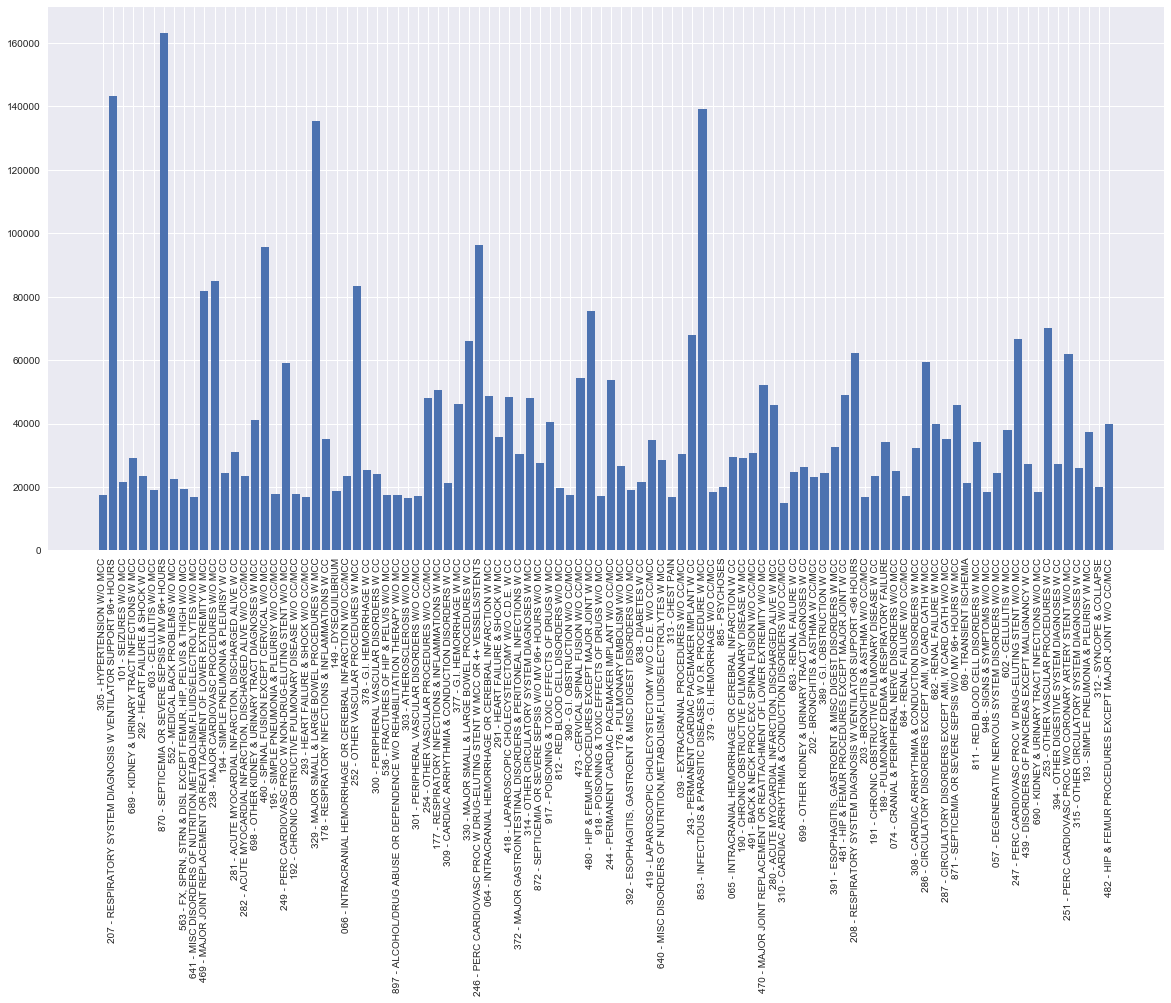

In [454]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(range(len(charges_keys)),charges_plot )
plt.xticks(range(len(charges_keys)), list(covered_charges_dict.keys()), rotation = 'vertical')

plt.show()

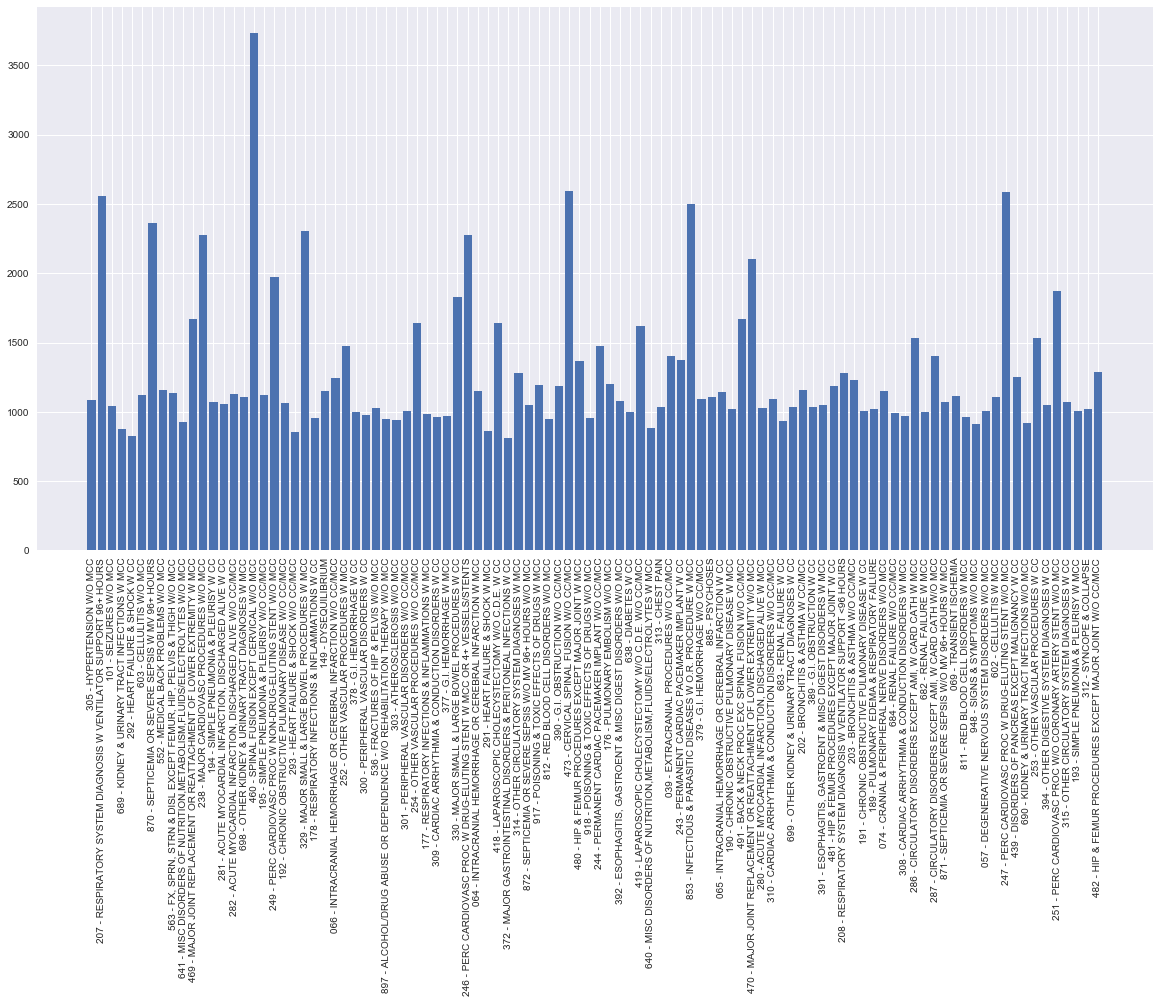

In [451]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(range(len(Patient_payment_keys)),Patient_payments_plot )
plt.xticks(range(len(Patient_payment_keys)), list(patient_payments_dict.keys()), rotation = 'vertical')

plt.show()

In [456]:
df_IPandProvider.columns

Index([u'DRG_Definition', u'Provider_ID', u'Provider_Name',
       u'Provider_Street_Address', u'Provider_City', u'Provider_State',
       u'Provider_Zip_Code', u'Hospital_Referral_Region_Description',
       u'Total_Discharges', u'Average_Covered_Charges',
       u'Average_Total_Payments', u'Average_Medicare_Payments',
       u'Hospital_Name', u'County_Name', u'Hospital_Type',
       u'Hospital_Ownership', u'Emergency_Services',
       u'Meets_criteria_for_meaningful_use_of_EHRs',
       u'Hospital_overall_rating', u'Mortality_national_comparison',
       u'Safety_of_care_national_comparison',
       u'Readmission_national_comparison',
       u'Patient_experience_national_comparison',
       u'Effectiveness_of_care_national_comparison',
       u'Timeliness_of_care_national_comparison',
       u'Efficient_use_of_medical_imaging_national_comparison',
       u'Patient_payment', u'Covered_Charges', u'Covered_Charges_Avg',
       u'Covered_Charges_Stdev', u'Total_Payments', u'Total_Payment

In [457]:
df_IPandProvider.head()

,DRG_Definition,Provider_ID,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_Description,Total_Discharges,Average_Covered_Charges,...,Covered_Charges_Stdev,Total_Payments,Total_Payments_Avg,Total_Payments_Stdev,Medicare_Payments,Medicare_Payments_Avg,Medicare_Payments_Std,Patient_Payments,Patient_Payments_Avg,Patient_Payments_Stdev
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,15941.252284,0,6960.534004,1477.873952,0,5555.837525,1236.063439,0,1404.696478,912.492377
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,15941.252284,0,6960.534004,1477.873952,0,5555.837525,1236.063439,0,1404.696478,912.492377
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,15941.252284,0,6960.534004,1477.873952,0,5555.837525,1236.063439,0,1404.696478,912.492377
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,15941.252284,0,6960.534004,1477.873952,0,5555.837525,1236.063439,1,1404.696478,912.492377
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,15941.252284,0,6960.534004,1477.873952,0,5555.837525,1236.063439,0,1404.696478,912.492377


In [500]:
df_Model_1 = df_IPandProvider.copy()

In [501]:
df_Model_1 = df_Model_1.drop(['Patient_payment','Patient_Payments_Stdev','Patient_Payments_Avg','Medicare_Payments_Std','Medicare_Payments_Avg','Total_Payments_Stdev','Total_Payments_Avg','Covered_Charges_Stdev','Covered_Charges_Avg','Provider_Name','Average_Covered_Charges','Provider_Street_Address','Provider_City','Hospital_Referral_Region_Description','Total_Discharges','Average_Total_Payments','Meets_criteria_for_meaningful_use_of_EHRs','Readmission_national_comparison','Patient_experience_national_comparison','Average_Medicare_Payments','Hospital_Name', 'County_Name'],1)
 


In [502]:
df_Model_1.columns

Index([u'DRG_Definition', u'Provider_ID', u'Provider_State',
       u'Provider_Zip_Code', u'Hospital_Type', u'Hospital_Ownership',
       u'Emergency_Services', u'Hospital_overall_rating',
       u'Mortality_national_comparison', u'Safety_of_care_national_comparison',
       u'Effectiveness_of_care_national_comparison',
       u'Timeliness_of_care_national_comparison',
       u'Efficient_use_of_medical_imaging_national_comparison',
       u'Covered_Charges', u'Total_Payments', u'Medicare_Payments',
       u'Patient_Payments'],
      dtype='object')

In [503]:
df_Model_1.head()

,DRG_Definition,Provider_ID,Provider_State,Provider_Zip_Code,Hospital_Type,Hospital_Ownership,Emergency_Services,Hospital_overall_rating,Mortality_national_comparison,Safety_of_care_national_comparison,Effectiveness_of_care_national_comparison,Timeliness_of_care_national_comparison,Efficient_use_of_medical_imaging_national_comparison,Covered_Charges,Total_Payments,Medicare_Payments,Patient_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,True,3,Same as the National average,Above the National average,Same as the National average,Same as the National average,Same as the National average,1,0,0,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,AL,35957,Acute Care Hospitals,Government - Hospital District or Authority,True,3,Below the National average,Same as the National average,Same as the National average,Above the National average,Below the National average,0,0,0,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,True,2,Below the National average,Same as the National average,Same as the National average,Above the National average,Same as the National average,2,0,0,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,AL,35235,Acute Care Hospitals,Voluntary non-profit - Private,True,2,Same as the National average,Below the National average,Below the National average,Same as the National average,Same as the National average,0,0,0,1
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,AL,35007,Acute Care Hospitals,Voluntary non-profit - Private,True,3,Same as the National average,Above the National average,Same as the National average,Below the National average,Below the National average,1,0,0,0


In [485]:
df_Model_1[['Patient_Payments','Covered_Charges', 'Total_Payments', 'Medicare_Payments','Efficient_use_of_medical_imaging_national_comparison','Timeliness_of_care_national_comparison','Effectiveness_of_care_national_comparison','Safety_of_care_national_comparison','Hospital_Type', 'Hospital_Ownership', 'Emergency_Services','Hospital_overall_rating', 'Mortality_national_comparison']].apply(pd.Series.value_counts)


,Patient_Payments,Covered_Charges,Total_Payments,Medicare_Payments,Efficient_use_of_medical_imaging_national_comparison,Timeliness_of_care_national_comparison,Effectiveness_of_care_national_comparison,Safety_of_care_national_comparison,Hospital_Type,Hospital_Ownership,Emergency_Services,Hospital_overall_rating,Mortality_national_comparison
False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2386.0,NaN,NaN
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156075.0,NaN,NaN
0,83899.0,82441.0,85380.0,86194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,42695.0,33658.0,32567.0,32937.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7136.0,NaN
2,36471.0,46966.0,45118.0,43934.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39444.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67856.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36324.0,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4100.0,NaN
Above the National average,NaN,NaN,NaN,NaN,29590.0,29270.0,9035.0,52137.0,NaN,NaN,NaN,NaN,30903.0
Acute Care Hospitals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158461.0,NaN,NaN,NaN,NaN


In [504]:
df_Model_1[df_Model_1.Efficient_use_of_medical_imaging_national_comparison == 'Not Available']

,DRG_Definition,Provider_ID,Provider_State,Provider_Zip_Code,Hospital_Type,Hospital_Ownership,Emergency_Services,Hospital_overall_rating,Mortality_national_comparison,Safety_of_care_national_comparison,Effectiveness_of_care_national_comparison,Timeliness_of_care_national_comparison,Efficient_use_of_medical_imaging_national_comparison,Covered_Charges,Total_Payments,Medicare_Payments,Patient_Payments
23,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,20017,AK,99508,Acute Care Hospitals,Proprietary,True,3,Same as the National average,Below the National average,Same as the National average,Same as the National average,Not Available,2,2,2,2
33,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30030,AZ,85015,Acute Care Hospitals,Proprietary,True,2,Same as the National average,Above the National average,Below the National average,Same as the National average,Not Available,0,2,2,0
43,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30094,AZ,85308,Acute Care Hospitals,Proprietary,True,3,Same as the National average,Same as the National average,Below the National average,Same as the National average,Not Available,1,1,2,0
47,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,30105,AZ,85206,Acute Care Hospitals,Voluntary non-profit - Private,False,5,Above the National average,Above the National average,Not Available,Not Available,Not Available,2,0,0,1
120,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50551,CA,90720,Acute Care Hospitals,Proprietary,True,2,Same as the National average,Same as the National average,Same as the National average,Below the National average,Not Available,2,1,0,1
128,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,50757,CA,92120,Acute Care Hospitals,Government - Federal,True,3,Above the National average,Above the National average,Same as the National average,Same as the National average,Not Available,1,1,2,0
180,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,100049,FL,33870,Acute Care Hospitals,Proprietary,True,2,Same as the National average,Below the National average,Same as the National average,Same as the National average,Not Available,2,0,0,1
191,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,100077,FL,33952,Acute Care Hospitals,Proprietary,True,2,Above the National average,Below the National average,Same as the National average,Below the National average,Not Available,2,0,0,0
219,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,100211,FL,33525,Acute Care Hospitals,Proprietary,True,2,Same as the National average,Same as the National average,Same as the National average,Same as the National average,Not Available,2,0,0,0
362,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,150153,IN,46290,Acute Care Hospitals,Proprietary,True,4,Same as the National average,Above the National average,Same as the National average,Same as the National average,Not Available,0,0,0,0


First model will be without ratings d/t data loss of specific hospital types if we leave them in 

In [505]:
df_Model_1a = df_Model_1.copy()

In [506]:
df_Model_1a = df_Model_1a.drop(['Hospital_Type','Efficient_use_of_medical_imaging_national_comparison','Timeliness_of_care_national_comparison','Effectiveness_of_care_national_comparison','Safety_of_care_national_comparison','Hospital_overall_rating', 'Mortality_national_comparison'],1)



In [507]:
df_Model_1a.head()

,DRG_Definition,Provider_ID,Provider_State,Provider_Zip_Code,Hospital_Ownership,Emergency_Services,Covered_Charges,Total_Payments,Medicare_Payments,Patient_Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,AL,36301,Government - Hospital District or Authority,True,1,0,0,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,AL,35957,Government - Hospital District or Authority,True,0,0,0,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,AL,35631,Government - Hospital District or Authority,True,2,0,0,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,AL,35235,Voluntary non-profit - Private,True,0,0,0,1
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,AL,35007,Voluntary non-profit - Private,True,1,0,0,0


In [508]:
df_Model_1a[['Patient_Payments','Covered_Charges', 'Total_Payments', 'Medicare_Payments', 'Hospital_Ownership', 'Emergency_Services']].apply(pd.Series.value_counts)
 

,Patient_Payments,Covered_Charges,Total_Payments,Medicare_Payments,Hospital_Ownership,Emergency_Services
False,NaN,NaN,NaN,NaN,NaN,2386.0
True,NaN,NaN,NaN,NaN,NaN,156075.0
0,83899.0,82441.0,85380.0,86194.0,NaN,NaN
1,42695.0,33658.0,32567.0,32937.0,NaN,NaN
2,36471.0,46966.0,45118.0,43934.0,NaN,NaN
Government - Federal,NaN,NaN,NaN,NaN,476.0,NaN
Government - Hospital District or Authority,NaN,NaN,NaN,NaN,11195.0,NaN
Government - Local,NaN,NaN,NaN,NaN,6254.0,NaN
Government - State,NaN,NaN,NaN,NaN,2461.0,NaN
Physician,NaN,NaN,NaN,NaN,487.0,NaN


In [509]:
df_Model_1a['Hospital_Ownership'] = df_Model_1a['Hospital_Ownership'].replace('Tribal','zTribal')

In [510]:
df_Model_1a[['Patient_Payments','Covered_Charges', 'Total_Payments', 'Medicare_Payments', 'Hospital_Ownership', 'Emergency_Services']].apply(pd.Series.value_counts)


,Patient_Payments,Covered_Charges,Total_Payments,Medicare_Payments,Hospital_Ownership,Emergency_Services
False,NaN,NaN,NaN,NaN,NaN,2386.0
True,NaN,NaN,NaN,NaN,NaN,156075.0
0,83899.0,82441.0,85380.0,86194.0,NaN,NaN
1,42695.0,33658.0,32567.0,32937.0,NaN,NaN
2,36471.0,46966.0,45118.0,43934.0,NaN,NaN
Government - Federal,NaN,NaN,NaN,NaN,476.0,NaN
Government - Hospital District or Authority,NaN,NaN,NaN,NaN,11195.0,NaN
Government - Local,NaN,NaN,NaN,NaN,6254.0,NaN
Government - State,NaN,NaN,NaN,NaN,2461.0,NaN
Physician,NaN,NaN,NaN,NaN,487.0,NaN


In [513]:
df_Model_1a.columns

Index([u'DRG_Definition', u'Provider_ID', u'Provider_State',
       u'Provider_Zip_Code', u'Hospital_Ownership', u'Emergency_Services',
       u'Covered_Charges', u'Total_Payments', u'Medicare_Payments',
       u'Patient_Payments'],
      dtype='object')

In [525]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

In [519]:
X = df_Model_1a.drop(['Provider_ID','Covered_Charges', 'Total_Payments', 'Medicare_Payments','Patient_Payments'],1)

In [521]:
X.columns

Index([u'DRG_Definition', u'Provider_State', u'Provider_Zip_Code',
       u'Hospital_Ownership', u'Emergency_Services'],
      dtype='object')

In [520]:
y = df_Model_1a['Covered_Charges']

In [522]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [529]:
le = preprocessing.LabelEncoder()
States = le.fit(X['Provider_State'])

In [532]:
X_coded = X.apply(preprocessing.LabelEncoder().fit_transform)

/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [533]:
X_coded

,DRG_Definition,Provider_State,Provider_Zip_Code,Hospital_Ownership,Emergency_Services
0,0,1,1098,2,131
1,0,1,1077,2,6149
2,0,1,1067,2,6149
3,0,1,1054,9,6149
4,0,1,1039,9,6149
5,0,1,1091,2,6149
6,0,1,1125,2,6149
7,0,1,1053,4,6149
8,0,1,1074,2,6149
9,0,1,1076,6,6149


In [540]:
X_train, X_test, y_train, y_test = train_test_split(X_coded, y, test_size=0.3)

In [556]:
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV(Cs=[0.1,1,10,100,1000,10000,100000,200000,300000], cv=10, random_state=1)
logregcv.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.1, 1, 10, 100, 1000, 10000, 100000, 200000, 300000],
           class_weight=None, cv=10, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=1, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [557]:
acc_train_cv = logregcv.score(X_train, y_train)
acc_test_cv = logregcv.score(X_test, y_test)
print("train_score=%.3f\ntest_score =%.3f\n" % (acc_train_cv, acc_test_cv))

train_score=0.559
test_score =0.557



In [558]:
print(logregcv.classes_)
print(logregcv.C_)
print(logregcv.intercept_)
print(logregcv.coef_)
print(logregcv.coefs_paths_)

['0' '1' '2']
[ 0.1  0.1  0.1]
[ 0.0006959  -0.3194424  -0.11824941]
[[  1.17922536e-03   1.85617356e-02  -3.84614853e-04   2.32039676e-03
    8.61966302e-06]
 [ -6.02567312e-03  -5.66872234e-03   6.52452343e-05  -5.68599764e-02
   -5.99305571e-05]
 [ -4.71600238e-03  -2.39742192e-02   2.58616224e-04  -2.23309656e-02
   -4.60840002e-05]]
{'1': array([[[ -7.72364079e-03,  -6.90744384e-03,   3.96036431e-05,
          -6.84737363e-02,  -7.72708891e-05,  -8.99714876e-03],
        [ -7.72364083e-03,  -6.90744389e-03,   3.96052212e-05,
          -6.84737346e-02,  -7.72655984e-05,  -8.99716180e-03],
        [ -7.72364087e-03,  -6.90744392e-03,   3.96038780e-05,
          -6.84737343e-02,  -7.72709486e-05,  -8.99716410e-03],
        [ -7.72364091e-03,  -6.90744397e-03,   3.96053762e-05,
          -6.84737326e-02,  -7.72656399e-05,  -8.99717712e-03],
        [ -7.72364095e-03,  -6.90744400e-03,   3.96040244e-05,
          -6.84737323e-02,  -7.72709854e-05,  -8.99717941e-03],
        [ -7.723640

In [559]:
logregcv.scores_

{'0': array([[ 0.57489488,  0.57489488,  0.57489488,  0.57489488,  0.57489488,
          0.57489488,  0.57489488,  0.57489488,  0.57489488],
        [ 0.57857393,  0.57848633,  0.57857393,  0.57848633,  0.57857393,
          0.57848633,  0.57857393,  0.57848633,  0.57857393],
        [ 0.5738064 ,  0.5738064 ,  0.5738064 ,  0.5738064 ,  0.5738064 ,
          0.5738064 ,  0.5738064 ,  0.5738064 ,  0.5738064 ],
        [ 0.57993868,  0.57993868,  0.57993868,  0.57993868,  0.57993868,
          0.57993868,  0.57993868,  0.57993868,  0.57993868],
        [ 0.57967587,  0.57967587,  0.57967587,  0.57967587,  0.57967587,
          0.57967587,  0.57967587,  0.57967587,  0.57967587],
        [ 0.57503285,  0.57503285,  0.57503285,  0.57503285,  0.57503285,
          0.57503285,  0.57503285,  0.57503285,  0.57503285],
        [ 0.57762397,  0.57762397,  0.57762397,  0.57762397,  0.57762397,
          0.57762397,  0.57762397,  0.57762397,  0.57762397],
        [ 0.56829931,  0.56829931,  0.56829

In [574]:
from sklearn.learning_curve import learning_curve

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [577]:
logreg = LogisticRegression(C=0.1)

In [579]:
train_sizes, train_scores, valid_scores = learning_curve(logreg, X_coded, y, cv=5)


In [580]:
train_cv_err = np.mean(train_scores, axis=1)
test_cv_err = np.mean(valid_scores, axis=1)

<function matplotlib.pyplot.show>

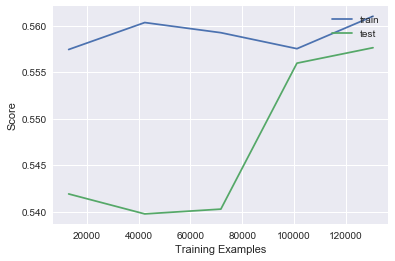

In [581]:
plt.plot(train_sizes,train_cv_err, label = "train")
plt.plot(train_sizes,test_cv_err, label = "test")
legend = plt.legend(loc='upper right', shadow=False)
plt.ylabel('Score')
plt.xlabel('Training Examples')
plt.show

Try KNN

0.650470155356


<function matplotlib.pyplot.show>

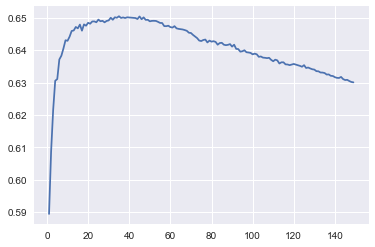

In [586]:
n_list = []
accuracy = []

for neighbors in range(1,150):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    n_list.append(neighbors)
    accuracy.append(accuracy_score(y_test, y_pred))

print(max(accuracy))    

plt.plot(n_list,accuracy)

plt.show


In [587]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

param_grid = {'n_neighbors': range(1, 100),
              'weights': ['uniform', 'distance']}

# select a randomized number of the parameter options
# the value set for `n_iter` determines how many
# options are selected
rand = RandomizedSearchCV(KNeighborsClassifier(), 
                          param_grid, 
                          cv=3, 
                          scoring='accuracy',
                          n_iter=10)

rand = rand.fit(X_train, y_train)

In [588]:
rand.cv_results_['mean_test_score']

array([ 0.6376889 ,  0.64447851,  0.63234482,  0.63318586,  0.65045337,
        0.62508213,  0.64476762,  0.6369968 ,  0.62324237,  0.64762364])

In [589]:
print(rand.best_estimator_, rand.best_score_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=73, p=2,
           weights='distance') 0.650453370713


In [590]:
print(accuracy_score(y_test, rand.best_estimator_.predict(X_test)))

0.656684382666


In [594]:
knn = KNeighborsClassifier(n_neighbors=73)

train_sizes_KNN, train_scores_KNN, valid_scores_KNN = learning_curve(knn,  X_coded, y, cv=3)


In [595]:
train_cv_err = np.mean(train_scores_KNN, axis=1)
test_cv_err = np.mean(valid_scores_KNN, axis=1)

<function matplotlib.pyplot.show>

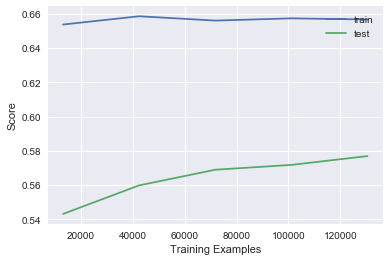

In [596]:
plt.plot(train_sizes,train_cv_err, label = "train")
plt.plot(train_sizes,test_cv_err, label = "test")
legend = plt.legend(loc='upper right', shadow=False)
plt.ylabel('Score')
plt.xlabel('Training Examples')
plt.show

In [597]:
classifier = LogisticRegression(C=1)
clf = classifier.fit(X_train, y_train)
train_acc=clf.score(X_train, y_train)
test_acc=clf.score(X_test, y_test)
#train_acc=accuracy_score(X_train, y_train)
#test_acc=accuracy_score(X_test, y_test)

print("Training Data Accuracy: %0.2f" %(train_acc))
print("Test Data Accuracy:     %0.2f" %(test_acc))

Training Data Accuracy: 0.56
Test Data Accuracy:     0.56


In [600]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[23183     0  1561]
 [ 8778     0  1304]
 [10017     0  4077]]


Test Data Accuracy:     0.56
Precision:              0.73
Recall:                 1.00
F1:                     0.84


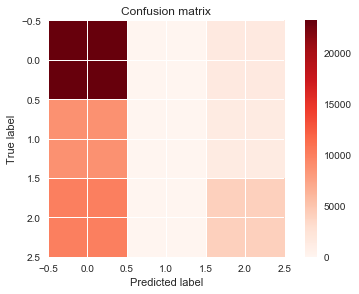

In [601]:
from patsy import dmatrices

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = clf.predict(X_test)


conf = confusion_matrix(y_true, y_pred)
precision = (conf[0, 0] / (conf[0, 0] + conf[1, 0]))
recall = (conf[0, 0] / (conf[0, 0] + conf[0, 1]))
F1 = 2*((precision*recall)/(precision+recall))
            
print(conf)
print ('\n')
print ("Test Data Accuracy:     %0.2f" %(test_acc))

print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("F1:                     %0.2f" % F1)
cm=confusion_matrix(y_true, y_pred, labels=None)
    
plt.figure()
plot_confusion_matrix(cm)

In [602]:
classifier.fit(X_train,np.ravel(y_train))
y_score=classifier.predict_proba(X_test)[:,1]

In [605]:
y_score

array([ 0.20776472,  0.17298101,  0.18169223, ...,  0.19215021,
        0.20034398,  0.18430812])

In [603]:
fpr, tpr,_ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

ValueError: Data is not binary and pos_label is not specified

In [608]:
df_Model_1a_HF = df_Model_1a[df_Model_1a.DRG_Definition == '291 - HEART FAILURE & SHOCK W MCC']

In [610]:
X_HF = df_Model_1a_HF.drop(['Provider_ID','Covered_Charges', 'Total_Payments', 'Medicare_Payments','Patient_Payments'],1)

In [615]:
y_HF = df_Model_1a_HF['Covered_Charges']

In [616]:
X_HFcoded = X_HF.apply(preprocessing.LabelEncoder().fit_transform)

In [618]:
from sklearn.preprocessing import label_binarize
y_HFcoded = label_binarize(y_HF,classes=[0, 1, 2])

In [626]:
X_train, X_test, y_train, y_test = train_test_split(X_HFcoded, y_HF, test_size=0.3)

In [625]:
y_HFcoded


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ..., 
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [627]:
from sklearn.linear_model import LogisticRegressionCV
logregcv = LogisticRegressionCV(Cs=[0.1,1,10,100,1000,10000,100000,200000,300000], cv=10, random_state=1)
logregcv.fit(X_train,y_train)

LogisticRegressionCV(Cs=[0.1, 1, 10, 100, 1000, 10000, 100000, 200000, 300000],
           class_weight=None, cv=10, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=1, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [628]:
acc_train_cv = logregcv.score(X_train, y_train)
acc_test_cv = logregcv.score(X_test, y_test)
print("train_score=%.3f\ntest_score =%.3f\n" % (acc_train_cv, acc_test_cv))

train_score=0.555
test_score =0.549



In [629]:
print(logregcv.classes_)
print(logregcv.C_)
print(logregcv.intercept_)
print(logregcv.coef_)
print(logregcv.coefs_paths_)

['0' '1' '2']
[ 0.1  0.1  0.1]
[-0.48565414 -1.49320878 -0.13953182]
[[ 0.          0.02974857 -0.00059755 -0.00116219  0.00522333]
 [ 0.         -0.00258616  0.00025892 -0.01165866 -0.00080647]
 [ 0.         -0.03329227  0.00046828  0.00243223 -0.00568168]]
{'1': array([[[  0.00000000e+00,  -5.00893858e-03,   2.83731718e-04,
          -1.48617054e-02,  -9.30182220e-04,  -1.43390966e+00],
        [  0.00000000e+00,  -5.00893868e-03,   2.83732356e-04,
          -1.48617057e-02,  -9.30182273e-04,  -1.43390966e+00],
        [  0.00000000e+00,  -5.00893924e-03,   2.83731677e-04,
          -1.48617072e-02,  -9.30182797e-04,  -1.43390966e+00],
        [  0.00000000e+00,  -5.00893934e-03,   2.83732410e-04,
          -1.48617075e-02,  -9.30182841e-04,  -1.43390966e+00],
        [  0.00000000e+00,  -5.00893991e-03,   2.83731729e-04,
          -1.48617089e-02,  -9.30183351e-04,  -1.43390966e+00],
        [  0.00000000e+00,  -5.00894000e-03,   2.83732460e-04,
          -1.48617092e-02,  -9.301833

26738.109949856756

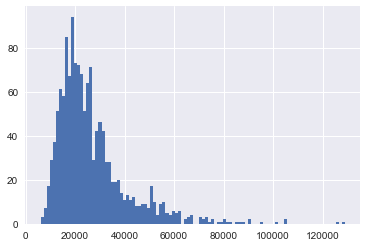

In [123]:
Pulmonary_embolism_df['Average_Covered_Charges'].hist(bins = 100)
Pulmonary_embolism_df['Average_Covered_Charges'].mean()

7279.95497851


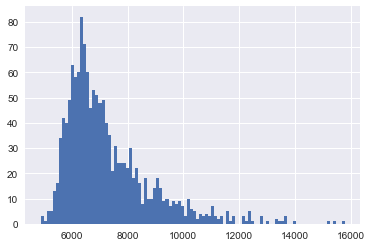

In [121]:
Pulmonary_embolism_df['Average_Total_Payments'].hist(bins = 100)
print(Pulmonary_embolism_df['Average_Total_Payments'].mean())

6077.94866046


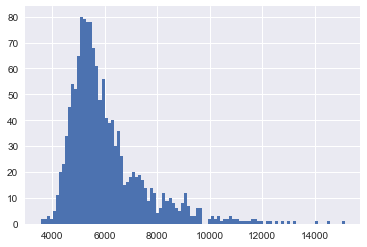

In [122]:
Pulmonary_embolism_df['Average_Medicare_Payments'].hist(bins = 100)
print(Pulmonary_embolism_df['Average_Medicare_Payments'].mean())


In [133]:
Pulmonary_embolism_df['Average_Medicare_Payments'].iloc[0]

5338.0900000000001

In [139]:
n=0
average_comp = []
for entry in Pulmonary_embolism_df['Average_Medicare_Payments']:
    if entry > Pulmonary_embolism_df['Average_Medicare_Payments'].mean():
        #Pulmonary_embolism_df['Medicare_Payments'].iloc[n] == '1'
        average_comp.append('1')
    else:
        #Pulmonary_embolism_df['Medicare_Payments'].iloc[n] == '0'
        average_comp.append('0')
    n=n+1

Pulmonary_embolism_df['Medicare_Payments'] = average_comp

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [140]:
Pulmonary_embolism_df.head()

,DRG_Definition,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Hospital_Referral_Region_Description,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Medicare_Payments
13536,176 - PULMONARY EMBOLISM W/O MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,33,23680.30,6020.27,5338.09,0
13537,176 - PULMONARY EMBOLISM W/O MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,14,23228.42,5599.57,4633.85,0
13538,176 - PULMONARY EMBOLISM W/O MCC,10010,MARSHALL MEDICAL CENTER NORTH,8000 ALABAMA HIGHWAY 69,GUNTERSVILLE,AL,35976,AL - Huntsville,12,12814.00,5446.41,4977.41,0
13539,176 - PULMONARY EMBOLISM W/O MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,17,18820.05,6294.29,4565.70,0
13540,176 - PULMONARY EMBOLISM W/O MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,17,31418.05,6328.70,4887.00,0


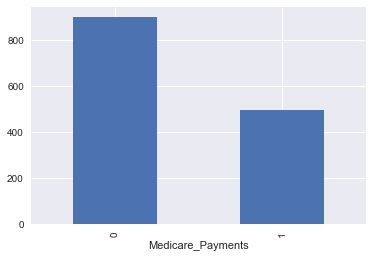

In [141]:
Pulmonary_embolism_df['Medicare_Payments'].groupby([Pulmonary_embolism_df.Medicare_Payments]).count().plot(kind = 'bar')